In [34]:
# Set up and Specific 1: Fit a linear regression and find coefficients and residuals

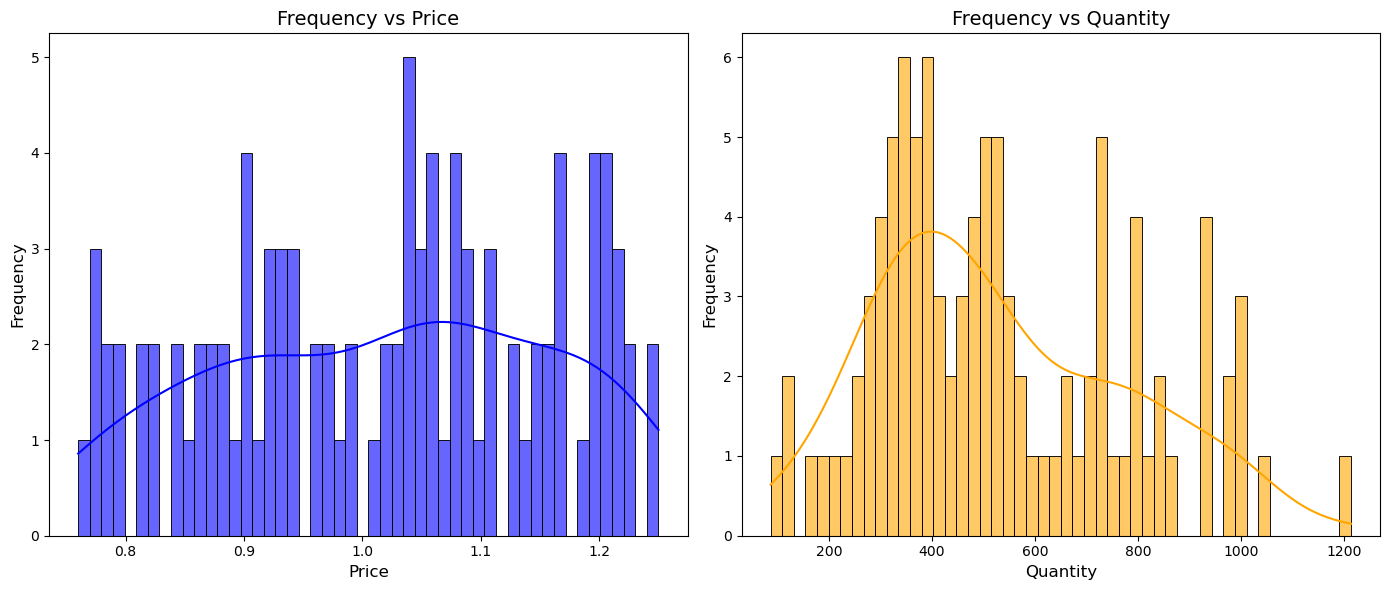

Estimated coefficients: beta_0 = 1924.72, beta_1 = -1367.71


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# Load the data
data = pd.read_csv('price_demand_data.csv')  # Replace with your data file
# Extract price and demand
prices = data['price']
demands = data['demand']

# Set up the figure
plt.figure(figsize=(14, 6))

# Plot for price
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.histplot(prices, kde=True, color='blue', bins=50, alpha=0.6)  # Histogram with KDE line
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency vs Price', fontsize=14)

# Plot for demand
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.histplot(demands, kde=True, color='orange', bins=50, alpha=0.6)  # Histogram with KDE line
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency vs Quantity', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

# Fit linear regression
coefficients = np.polyfit(prices, demands, 1)
beta_1, beta_0 = coefficients
print(f"Estimated coefficients: beta_0 = {beta_0:.2f}, beta_1 = {beta_1:.2f}")

In [36]:
# Calculate predicted demands
predicted_demands = beta_0 + beta_1 * prices

# Calculate residuals
residuals = demands - predicted_demands

# Add residuals to the data
data['residuals'] = residuals

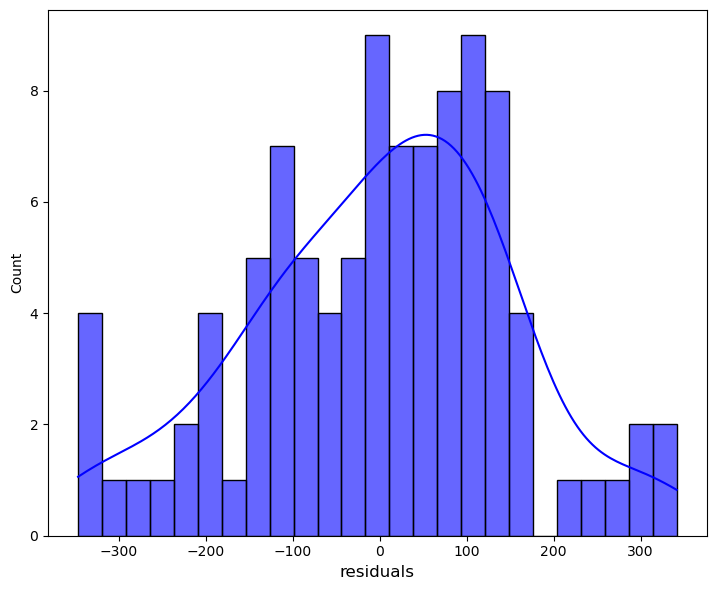

In [37]:
plt.figure(figsize=(14, 6))
# Plot for price
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.histplot(residuals, kde=True, color='blue', bins=25, alpha=0.6)  # Histogram with KDE line
plt.xlabel('residuals', fontsize=12)
plt.tight_layout()
plt.show()

In [38]:
#Specifics 2 & 3: Define constants and simulate demand using residuals - Solve for optimal 

In [39]:
# Fixed price
p_fixed = 1

# Compute base demand at p = 1
base_demand = beta_0 + beta_1 * p_fixed

# Generate demand data
D_i = base_demand + residuals

# Ensure non-negative demand
D_i = np.maximum(D_i, 0)
print(D_i)

# Add D_i to the data
data['D_i'] = D_i

0     351.385626
1     579.520247
2     472.219630
3     448.937249
4     673.748994
         ...    
94    498.802628
95    669.103245
96    441.708501
97    858.354250
98    601.448378
Length: 99, dtype: float64


In [40]:
import gurobipy as gp
from gurobipy import GRB
# Parameters
c = 0.5
n = len(D_i)
p = p_fixed  # Fixed price
# Create a Gurobi model
model = gp.Model("standard_NVM")
model.setParam('OutputFlag', 0)  # Suppress output

# Decision variable
q = model.addVar(lb=0, vtype=GRB.CONTINUOUS)

# Auxiliary variables
h_dummy = model.addVars(n, vtype=GRB.CONTINUOUS)

# Objective function
profit = gp.quicksum((h_dummy[i]) for i in range(n)) / n
model.setObjective(profit, GRB.MAXIMIZE)

# Constraints
for i in range(n):
    model.addConstr(h_dummy[i] <= D_i[i]*p - q*c)
    model.addConstr(h_dummy[i] <= p*q - q*c)
    
# Optimize
model.optimize()

# Results
if model.status == GRB.OPTIMAL:
    optimal_q = q.X
    optimal_profit = model.ObjVal
    print(f"Optimal production quantity q: {optimal_q:.2f}")
    print(f"Optimal expected profit: {optimal_profit:.2f}")
else:
    print("Optimization was not successful.")

Optimal production quantity q: 420.19
Optimal expected profit: 193.09


In [41]:
import gurobipy as gp
from gurobipy import GRB

# Parameters
c = 0.5 # Base production cost
g = 0.75 # Rush cost
t = 0.15 # Disposal cost
n = len(D_i)
p = p_fixed  # Fixed price

# Create a Gurobi model
model = gp.Model("Newsvendor_LP")
model.setParam('OutputFlag', 0)  # Suppress output

# Decision variable: q
q = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name="q")

# Auxiliary variables: s_i^+, s_i^-
s_plus = model.addVars(n, lb=0, vtype=GRB.CONTINUOUS, name="s_plus")
s_minus = model.addVars(n, lb=0, vtype=GRB.CONTINUOUS, name="s_minus")

# Objective function
profit = gp.quicksum((p * D_i[i] - c * q - g * s_plus[i] - t * s_minus[i]) for i in range(n)) / n
model.setObjective(profit, GRB.MAXIMIZE)

# Constraints
for i in range(n):
    model.addConstr(s_plus[i] >= D_i[i] - q, name=f"s_plus_constr_{i}")
    model.addConstr(s_minus[i] >= q - D_i[i], name=f"s_minus_constr_{i}")

# Optimize
model.optimize()

# Results
if model.status == GRB.OPTIMAL:
    optimal_q = q.X
    optimal_profit = model.ObjVal
    print(f"Optimal production quantity q: {optimal_q:.2f}")
    print(f"Optimal expected profit: {optimal_profit:.2f}")
else:
    print("Optimization was not successful.")

Optimal production quantity q: 471.87
Optimal expected profit: 231.48


In [42]:
#Specific 4: QCP Model

In [43]:
"""
Solves the QCP for optimal price and quantity.
This reformulates the stochastic programming objective into a deterministic QCP.
"""

# Create a Gurobi model
model = gp.Model("Newsvendor_QCP")
model.setParam('OutputFlag', 0)

# Decision variables: p and q
p = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name="p")
q = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name="q")

# Auxiliary variables: s_i^+, s_i^-
s_plus = model.addVars(n, lb=0, vtype=GRB.CONTINUOUS, name="s_plus")
s_minus = model.addVars(n, lb=0, vtype=GRB.CONTINUOUS, name="s_minus")

# Precompute constants
epsilon_i = data['residuals'].values

# Objective function
profit_terms = []
for i in range(n):
    D_i = beta_0 + beta_1 * p + epsilon_i[i]
    profit_term = (p * D_i - c * q - g * s_plus[i] - t * s_minus[i]) / n
    profit_terms.append(profit_term)

# Set objective
model.setObjective(gp.quicksum(profit_terms), GRB.MAXIMIZE)

# Constraints
for i in range(n):
    D_i = beta_0 + beta_1 * p + epsilon_i[i]
    model.addConstr(s_plus[i] >= D_i - q, name=f"s_plus_constr_{i}")
    model.addConstr(s_minus[i] >= q - D_i, name=f"s_minus_constr_{i}")

# Optimize
model.optimize()

# Results
if model.status == GRB.OPTIMAL:
    optimal_p = p.X
    optimal_q = q.X
    optimal_profit = model.ObjVal
    print(f"Optimal price p: {optimal_p:.2f}")
    print(f"Optimal production quantity q: {optimal_q:.2f}")
    print(f"Optimal expected profit: {optimal_profit:.2f}")
else:
    print("Optimization was not successful.")

Optimal price p: 0.95
Optimal production quantity q: 535.29
Optimal expected profit: 234.42


In [44]:
#Specifics 6 & 7: Bootstrap Sampling and Analytics

In [45]:
num_samples = 1000
bootstrap_p = []
bootstrap_q = []
bootstrap_profit = []

for i in tqdm(range(num_samples)):
    # Bootstrap sample
    bootstrap_data = data.sample(n=n, replace=True)
    bootstrap_prices = bootstrap_data['price']
    bootstrap_demands = bootstrap_data['demand']

    # Fit regression model
    coefficients = np.polyfit(bootstrap_prices, bootstrap_demands, 1)
    beta_1_bs, beta_0_bs = coefficients

    # Calculate residuals
    residuals_bs = bootstrap_demands - (beta_0_bs + beta_1_bs * bootstrap_prices)

    # Create Gurobi model
    model_bs = gp.Model(f"Newsvendor_QCP_{i}")
    model_bs.setParam('OutputFlag', 0)

    # Decision variables
    p_bs = model_bs.addVar(lb=0, vtype=GRB.CONTINUOUS, name="p")
    q_bs = model_bs.addVar(lb=0, vtype=GRB.CONTINUOUS, name="q")
    s_plus_bs = model_bs.addVars(n, lb=0, vtype=GRB.CONTINUOUS, name="s_plus")
    s_minus_bs = model_bs.addVars(n, lb=0, vtype=GRB.CONTINUOUS, name="s_minus")
    D_j_vars = model_bs.addVars(n, lb=0, vtype=GRB.CONTINUOUS, name="D_j")
    D_expr_vars = model_bs.addVars(n, vtype=GRB.CONTINUOUS, name="D_expr")

    profit_terms_bs = []

    for j in range(n):
        # Define D_expr_vars[j] as the expression for demand
        model_bs.addConstr(
            D_expr_vars[j] == beta_0_bs + beta_1_bs * p_bs + residuals_bs.values[j],
            name=f"D_expr_constr_{j}"
        )

        # Use addGenConstrMax with variables
        model_bs.addGenConstrMax(
            D_j_vars[j], [D_expr_vars[j], 0], name=f"D_max_constr_{j}"
        )

        # Profit term
        profit_term_bs = (
            p_bs * D_j_vars[j] - c * q_bs - g * s_plus_bs[j] - t * s_minus_bs[j]
        ) / n
        profit_terms_bs.append(profit_term_bs)

    # Set objective
    model_bs.setObjective(gp.quicksum(profit_terms_bs), GRB.MAXIMIZE)

    # Constraints
    for j in range(n):
        model_bs.addConstr(
            s_plus_bs[j] >= D_j_vars[j] - q_bs, name=f"s_plus_constr_{j}"
        )
        model_bs.addConstr(
            s_minus_bs[j] >= q_bs - D_j_vars[j], name=f"s_minus_constr_{j}"
        )

    # Optimize
    model_bs.optimize()

    # Check optimization status
    if model_bs.status == GRB.OPTIMAL:
        bootstrap_p.append(p_bs.X)
        bootstrap_q.append(q_bs.X)
        bootstrap_profit.append(model_bs.ObjVal)
    else:
        print(f"Optimization failed for sample {i}")

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:31<00:00,  6.61it/s]


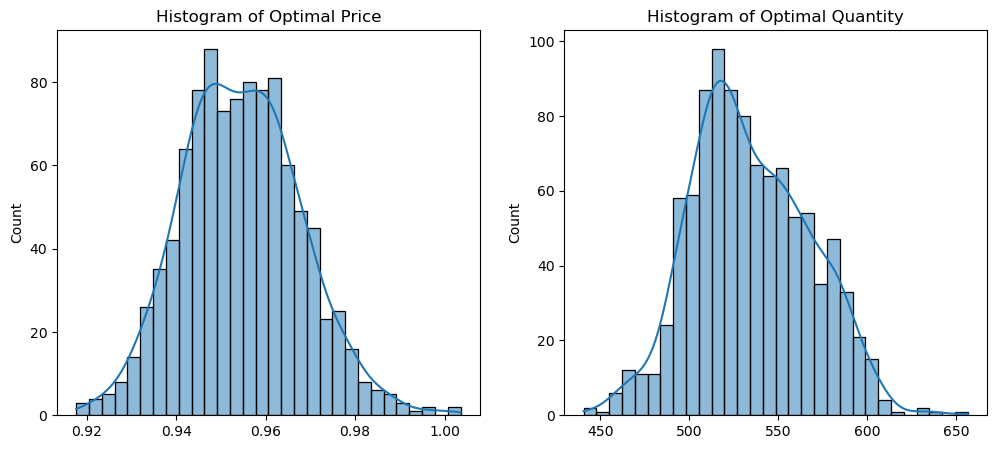

In [46]:
import seaborn as sns

# Convert to numpy arrays
bootstrap_p = np.array(bootstrap_p)
bootstrap_q = np.array(bootstrap_q)
bootstrap_profit = np.array(bootstrap_profit)

# Histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(bootstrap_p, kde=True, bins=30)
plt.title('Histogram of Optimal Price')

plt.subplot(1, 2, 2)
sns.histplot(bootstrap_q, kde=True, bins=30)
plt.title('Histogram of Optimal Quantity')

plt.show()

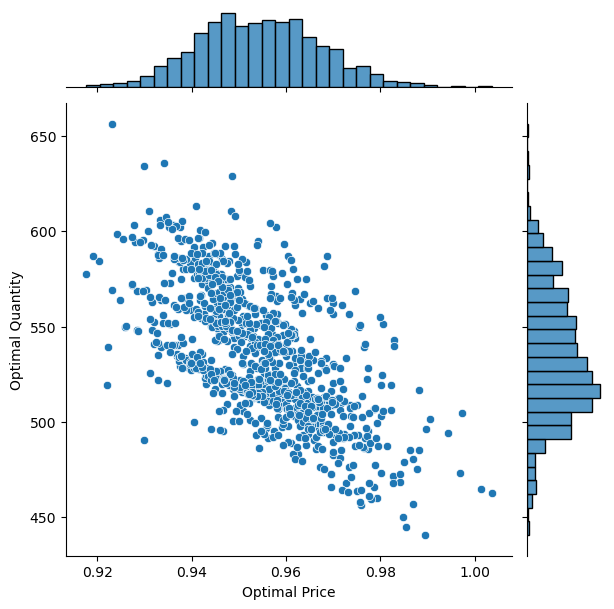

In [47]:
# Joint plot with histograms
sns.jointplot(x=bootstrap_p, y=bootstrap_q, kind='scatter', marginal_kws=dict(bins=30, fill=True))
plt.xlabel('Optimal Price')
plt.ylabel('Optimal Quantity')
plt.show()

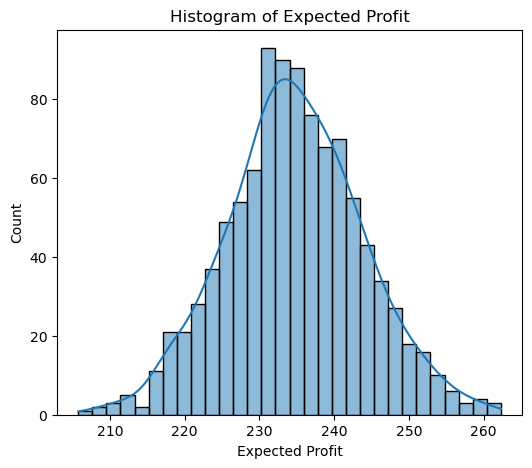

In [48]:
plt.figure(figsize=(6, 5))
sns.histplot(bootstrap_profit, kde=True, bins=30)
plt.title('Histogram of Expected Profit')
plt.xlabel('Expected Profit')
plt.show()

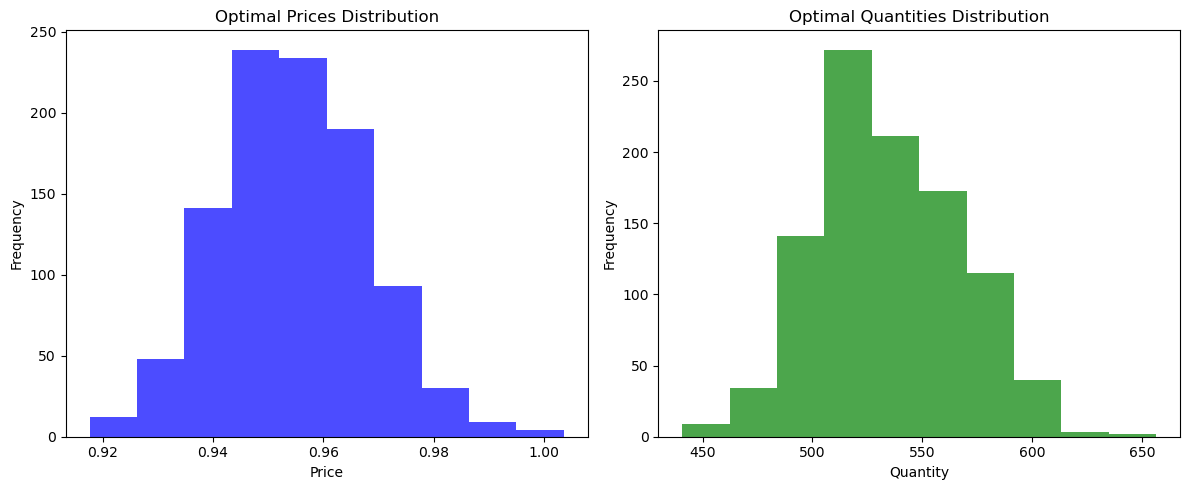

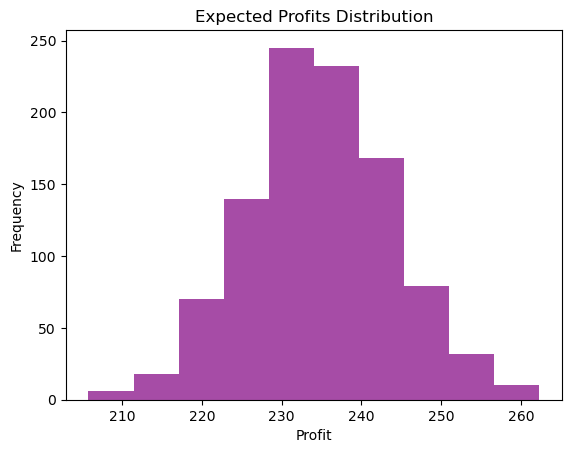

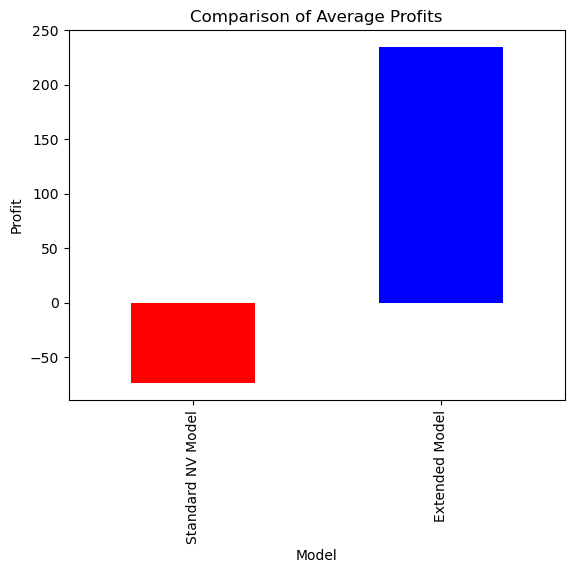

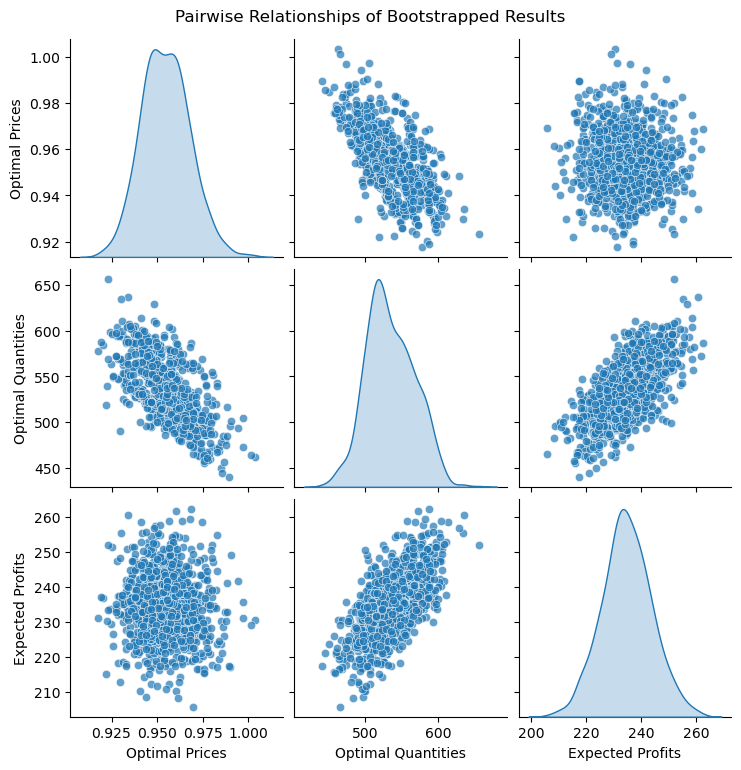

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Histograms for prices, quantities, and profits
plt.figure(figsize=(12, 5))

# Optimal Prices
plt.subplot(1, 2, 1)
plt.hist(bootstrap_p, bins=10, color='blue', alpha=0.7)
plt.title("Optimal Prices Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Optimal Quantities
plt.subplot(1, 2, 2)
plt.hist(bootstrap_q, bins=10, color='green', alpha=0.7)
plt.title("Optimal Quantities Distribution")
plt.xlabel("Quantity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Expected Profits
plt.figure()
plt.hist(bootstrap_profit, bins=10, color='purple', alpha=0.7)
plt.title("Expected Profits Distribution")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.show()


# Comparison with Standard Newsvendor Model
def standard_newsvendor(demands, price, cost):
    optimal_quantity = max(demands)
    expected_profit = np.mean([price * min(optimal_quantity, d) - optimal_quantity * cost for d in demands])
    return optimal_quantity, expected_profit

# Compute Standard NV Model Metrics
standard_optimal_quantity, standard_expected_profit = standard_newsvendor(data['demand'], price=1, cost=c)
extended_avg_profit = np.mean(bootstrap_profit)

# Comparison Bar Chart
comparison_data = pd.DataFrame({
    "Model": ["Standard NV Model", "Extended Model"],
    "Average Profit": [standard_expected_profit, extended_avg_profit]
})
comparison_data.plot(kind="bar", x="Model", y="Average Profit", legend=False, color=["red", "blue"])
plt.title("Comparison of Average Profits")
plt.ylabel("Profit")
plt.show()

# Pairplot for Bootstrapped Results
bootstrap_results_df = pd.DataFrame({
    "Optimal Prices": bootstrap_p,
    "Optimal Quantities": bootstrap_q,
    "Expected Profits": bootstrap_profit
})
sns.pairplot(bootstrap_results_df, diag_kind="kde", plot_kws={"alpha": 0.7})
plt.suptitle("Pairwise Relationships of Bootstrapped Results", y=1.02)
plt.show()


